# CUMUL

This notebook is an attempt to recreate teh CUMUL solution for WFA proposed by XXXX in 2017?

The code was not provided, so this is an approximation based on the description in the paper.

In [1]:
import os
import numpy as np
from scapy.all import *

In [2]:
CLIENT_SUBNET = "172"
PCAP_PATH = "pcaps/AWS_4_host/1r1g.com-WFA-winclient-3-102-15-2023_04_03__13_57_45.pcap"

In [3]:
DIR = "pcaps/big_capture"


In [4]:

def is_inbound(packet):
    if packet[IP].src[:3] == CLIENT_SUBNET:
        return False
    else:
        return True

# Pack order based encoder

In [5]:
def analyze_pcap_by_count(pcap_path):
    packets = rdpcap(pcap_path)
    num_samples = 100
    total_packets = len(packets)
    interval = total_packets / num_samples

    running_total = 0
    sampled_totals = []

    for i, packet in enumerate(packets):
        if IP not in packet:
            continue

        packet_size = packet[IP].len
        if is_inbound(packet):
            running_total += packet_size
        else:
            running_total -= packet_size

        if i >= len(sampled_totals) * interval:
            sampled_totals.append(running_total)

    # If there are fewer sampled totals than required, pad the list with the last running total
    while len(sampled_totals) < num_samples:
        sampled_totals.append(running_total)

    # Convert the list of sampled totals to a NumPy array
    sampled_totals_array = np.array(sampled_totals)

    return sampled_totals_array



result_array_by_count = analyze_pcap_by_count(PCAP_PATH)
print(result_array_by_count)


[      66    16830    61482   122425   234582   331291   436824   556999
   717057   844821   921277  1034189  1178166  1307083  1429001  1575802
  1737383  1837949  1975585  2142922  2199261  2344093  2462408  2636751
  2826779  2855578  2998794  3116965  3290244  3442989  3467582  3580968
  3753733  3823795  3942657  4091964  4214559  4358194  4539558  4612444
  4748895  4939078  4961147  5129701  5216166  5381526  5480638  5624592
  5739318  5906219  6012233  6127447  6300588  6380931  6576472  6715648
  6796560  6964017  7051043  7117781  7155354  7193793  7260464  7305113
  7334544  7521822  7722711  7833067  7828113  7868448  7902646  8011248
  8123370  8246343  8369867  8532738  8626683  8759991  8889254  9024303
  9144476  9275118  9405850  9553905  9692778  9883862 10077671 10165802
 10197175 10303947 10450775 10616730 10787215 10828653 10949605 11138322
 11327724 11359756 11448555 11538580]


# Time based encoder

In [6]:
def analyze_pcap_by_time(pcap_path):
    packets = rdpcap(pcap_path)
    num_samples = 100
    pcap_duration = 20  # 20 seconds
    interval = pcap_duration / num_samples

    running_total = 0
    sampled_totals = []
    current_sample_time = interval
    last_packet_time = packets[0].time

    for packet in packets:
        if IP not in packet:
            continue

        packet_size = packet[IP].len
        if is_inbound(packet):
            running_total += packet_size
        else:
            running_total -= packet_size

        packet_time = packet.time - last_packet_time
        while packet_time >= current_sample_time and len(sampled_totals) < num_samples:
            sampled_totals.append(running_total)
            current_sample_time += interval

    # If there are fewer sampled totals than required, pad the list with the last running total
    while len(sampled_totals) < num_samples:
        sampled_totals.append(running_total)

    # Convert the list of sampled totals to a NumPy array
    sampled_totals_array = np.array(sampled_totals)

    return sampled_totals_array



result_array_by_time = analyze_pcap_by_time(PCAP_PATH)
print(result_array_by_time)

[     -54      -54     4694     4994     5100     5202     5442     5340
     5360     5468     5588     3815     4708     4559     9937     9300
     9300    20016    36204    36204    36204    36204    36204    36573
    61212    58622    58068   246277   317661   317765   317765   317647
   322733   425548   926389  1110272  1847849  2367563  2915003  3434904
  3822106  4615684  4957142  5216166  5735181  6382310  7049243  7048263
  7117512  7144192  7156060  7317066  7328139  7723619  7825379  7827121
  7828539  7831586  7833346  7833426  7832775  7824047  7833296  7875296
  7879285  7880629  7882019  7886144  7903345  7964673  8075355  8511634
  8809574  9581452 10194957 10544903 11356176 11540464 11540645 11535232
 11536222 11536402 11536402 11536402 11536402 11536402 11536402 11536402
 11536402 11536402 11536402 11536402 11536402 11536402 11536402 11536402
 11536402 11536402 11536402 11536402]


In [7]:
def process_pcaps_in_directory(directory_path):
    features = []
    labels = []

    for file_name in os.listdir(directory_path):
        if file_name.endswith('.pcap'):
            pcap_path = os.path.join(directory_path, file_name)
            pcap_features = analyze_pcap_by_count(pcap_path)
            features.append(pcap_features)

            label = file_name.split('-')[0]
            labels.append(label)

    features_array = np.array(features)
    labels_array = np.array(labels)

    return features_array, labels_array

In [8]:
features, labels = process_pcaps_in_directory(DIR)

# Visualiser  

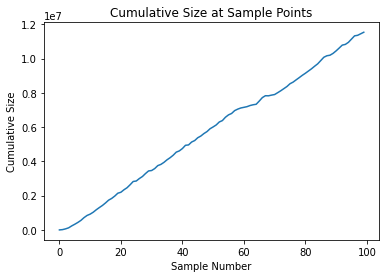

In [9]:
import matplotlib.pyplot as plt

def plot_encoded_array(encoded_array):
    # Create the x axis values (sample numbers)
    x = range(len(encoded_array))

    # Create a line plot with the x and y values
    plt.plot(x, encoded_array)

    # Set the x and y axis labels
    plt.xlabel('Sample Number')
    plt.ylabel('Cumulative Size')

    # Add a title for the plot
    plt.title('Cumulative Size at Sample Points')

    # Display the plot
    plt.show()

# Usage example
# Assuming the encoded_array variable has already been generated
plot_encoded_array(result_array_by_count)


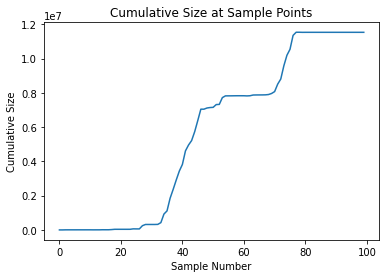

In [10]:
plot_encoded_array(result_array_by_time)

# ML Models

In [11]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train and evaluate the K-NN model
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)

print("K-NN Model:")
print(confusion_matrix(y_test, y_pred_knn))
print(classification_report(y_test, y_pred_knn))

# Train and evaluate the SVM model
svm = SVC(kernel='linear', C=1)
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)

print("SVM Model:")
print(confusion_matrix(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_svm))


K-NN Model:
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


/Users/michaelkearney/.local/share/virtualenvs/UNB_Datasets-qeLdalLc/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/michaelkearney/.local/share/virtualenvs/UNB_Datasets-qeLdalLc/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/michaelkearney/.local/share/virtualenvs/UNB_Datasets-qeLdalLc/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_di

                                  precision    recall  f1-score   support

                      0101.co.jp       0.00      0.00      0.00         0
                   0123movie.net       0.00      0.00      0.00         1
                  0123movies.com       0.00      0.00      0.00         0
                       01thy.top       0.00      0.00      0.00         1
            0azyk8qmjwhpbtr8.com       0.00      0.00      0.00         1
                       0cili.org       0.00      0.00      0.00         0
                0e753bd14f66.com       0.00      0.00      0.00         1
                    0gomovies.sk       0.00      0.00      0.00         1
              0unvefyh7t0yvq.com       0.00      0.00      0.00         1
                0v3v374o8zj1.top       0.00      0.00      0.00         0
            0yu5a5lqem51w3r1.com       0.00      0.00      0.00         1
                       1000.menu       0.00      0.00      0.00         1
                     10000.gd.cn     

/Users/michaelkearney/.local/share/virtualenvs/UNB_Datasets-qeLdalLc/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/michaelkearney/.local/share/virtualenvs/UNB_Datasets-qeLdalLc/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/michaelkearney/.local/share/virtualenvs/UNB_Datasets-qeLdalLc/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_di